You can follow along and play with this notebook by clicking the badge below

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/COGS118A/demo_notebooks/blob/main/lecture_08_trees_and_neighbors.ipynb)

# Trees

### Psuedo-code for a decision tree algorithm

You don't need this at all.  This is just a review of the idea that was in the slides :)

```python
def build_tree(S):
    # inputs: dataset S
    # outputs: a (sub)tree 
    if stop_criteria(S): # typically S is pure OR len(S) < some value
        return leaf_node(S)
    else:
        # typically optimal_test() picks a 
        # test `t_star` (e.g., a feature and a decision threshold)
        # that creates `partitions` of S such that
        # those partitions maximize an information metric
        # i.e., each partition is mostly just a single class
        t_star, partitions = optimal_test(S)
        
        children=[]
        for child_S in partitions:
            children.append( build_tree(child_S) )
        return (t_star + children)
```        

In [2]:
# two useful data viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

# setup plotting in a notebook in a reasonable way
%matplotlib inline
%config InlineBackend.figure_format='retina'

# default figure aesthetics I'll be using, 
# there are other choices, see seaborn docs
sns.set_style("darkgrid")
sns.set_context("notebook")

In [3]:
# lets get some 🐧 data to work with
penguins = sns.load_dataset("penguins").dropna()
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


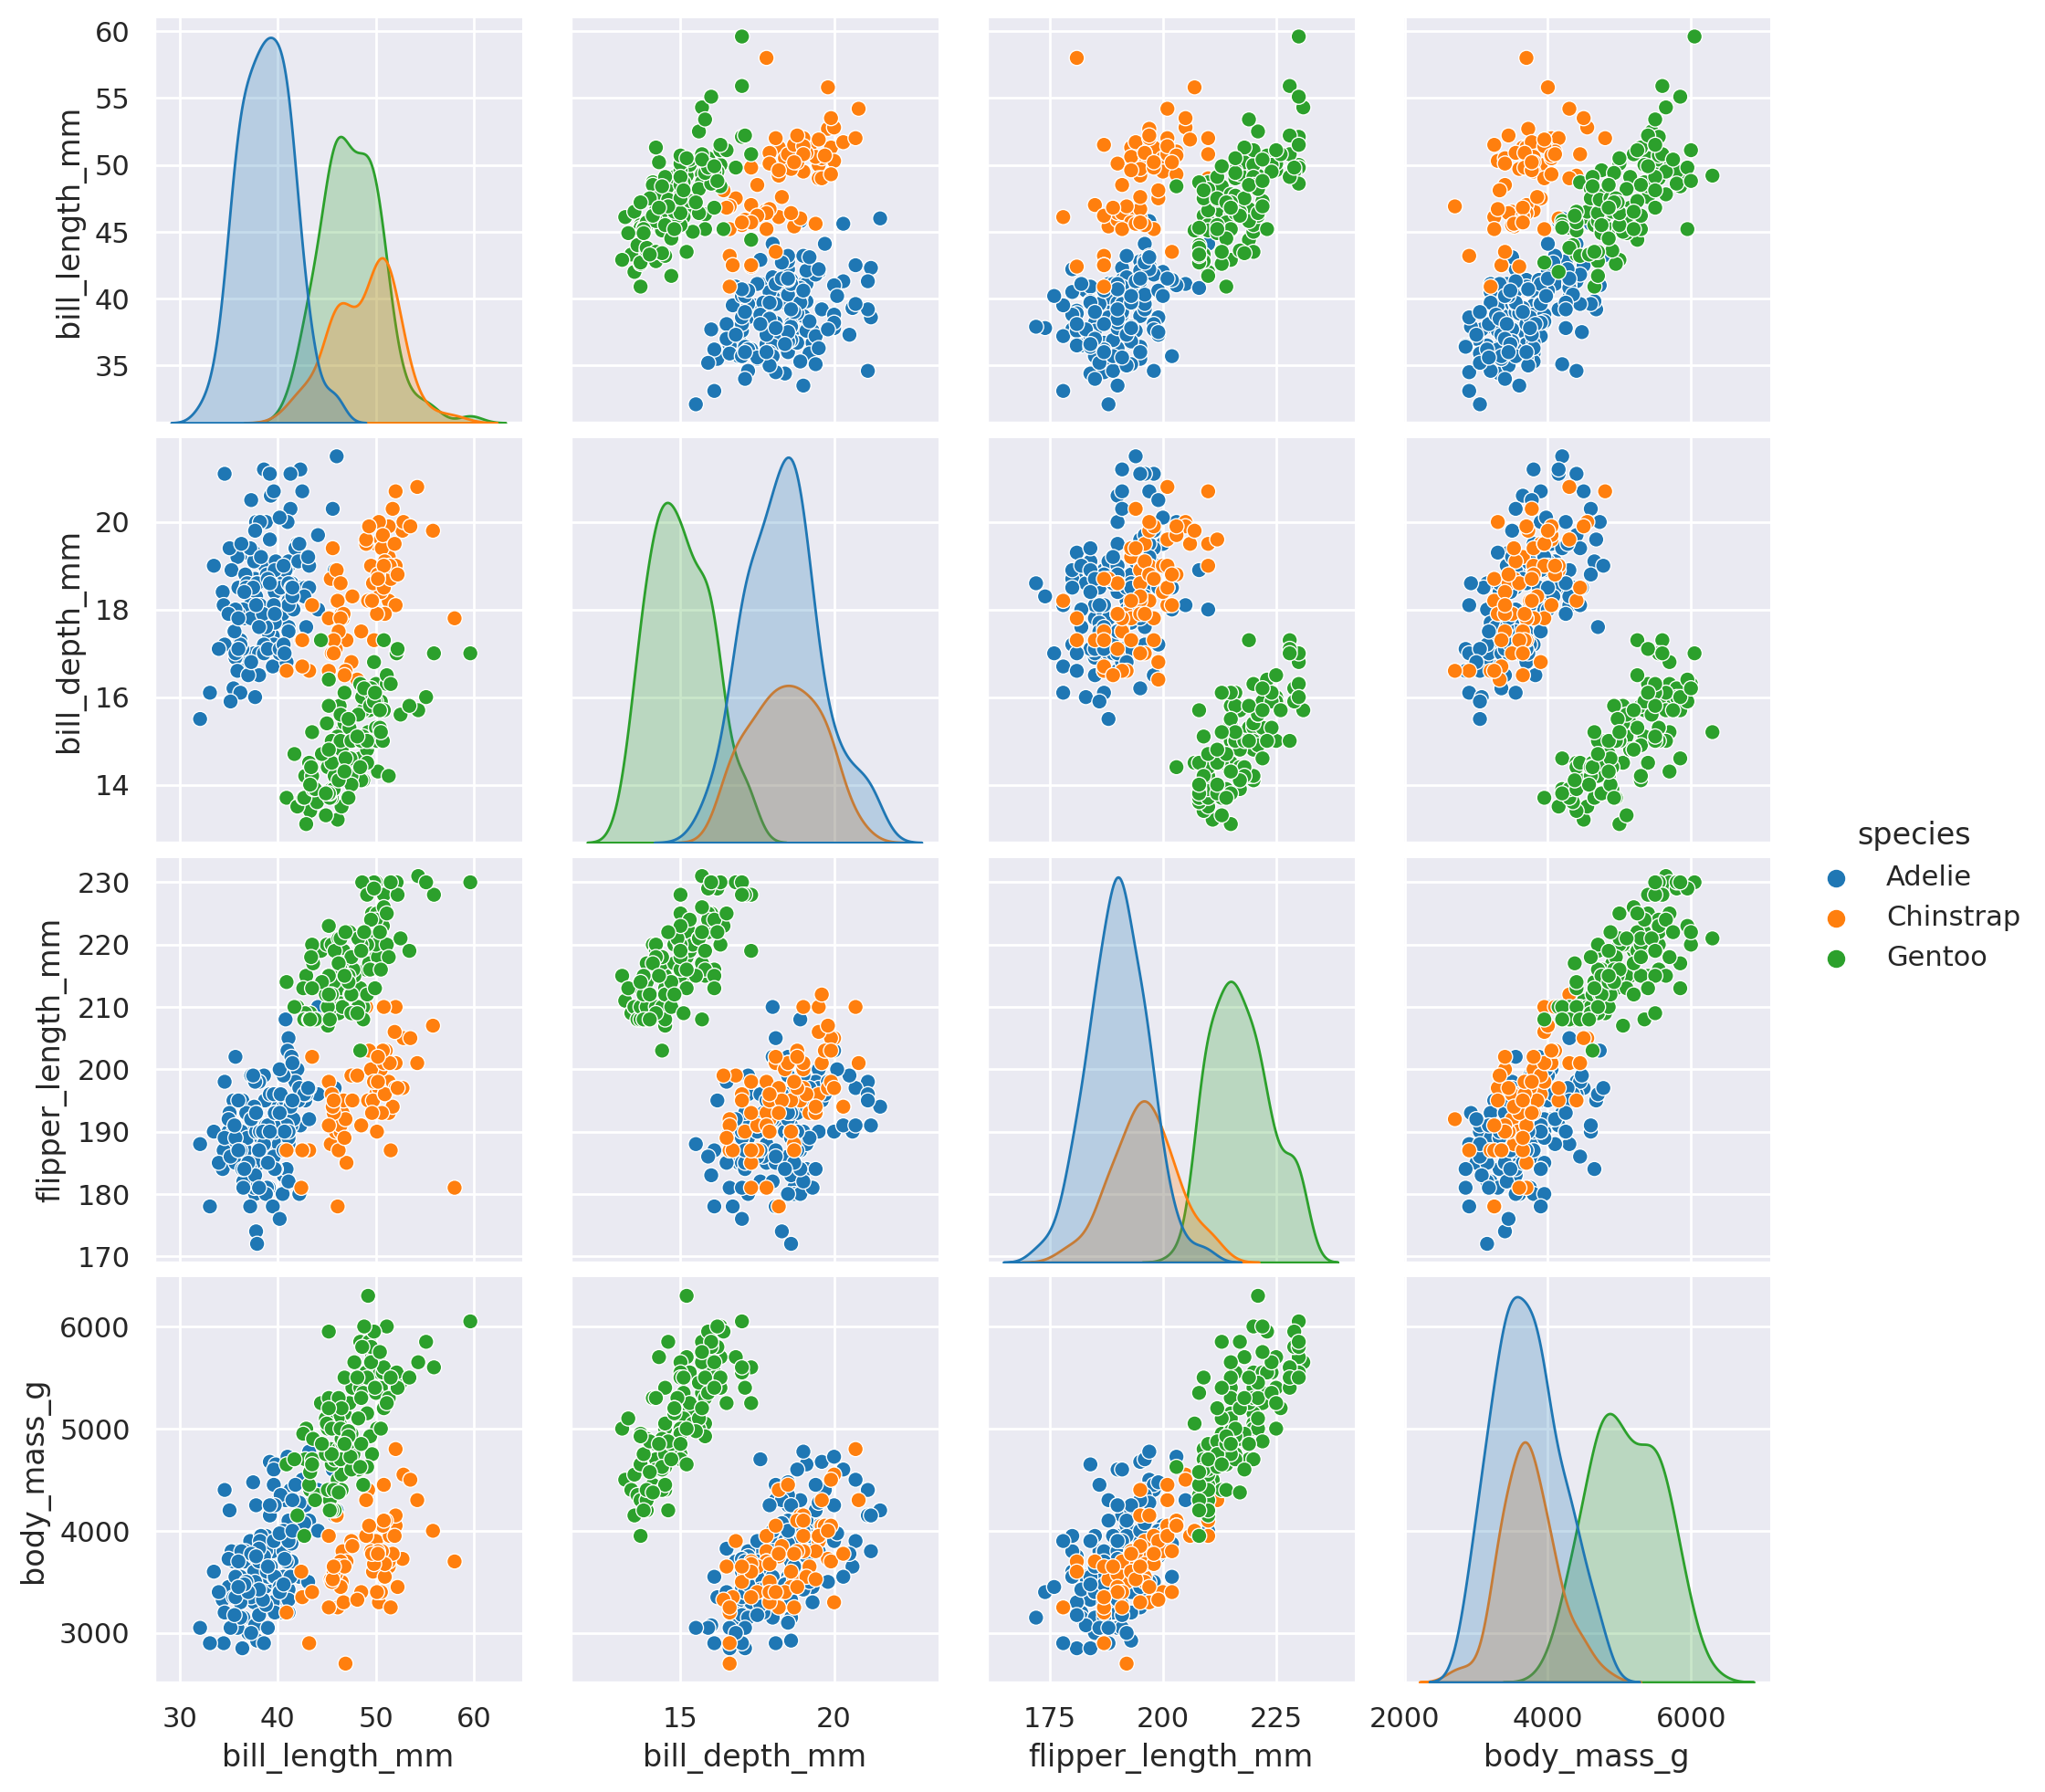

In [4]:
# for functions that return a graphics handle
# putting a ; afterwards supressed the echo
# of the handle to the screen when its the last line
# of a cell
sns.pairplot(penguins, hue='species');

In [5]:
from sklearn.model_selection import train_test_split

# here's our raw data
X = penguins[['bill_length_mm', 'bill_depth_mm', 
                  'flipper_length_mm', 'body_mass_g']] #, 'sex']]
y = penguins['species']

# make a train test split with params
# test_size=0.33, random_state=42
# see sklearn docs!

# YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(223, 4) (110, 4) (223,) (110,)


In [6]:
# models we will use
from sklearn.tree import DecisionTreeClassifier

# here's our model!  look at the docs for options!!
# right now we are going to use the defaults.
model = DecisionTreeClassifier()

In [9]:
# fit it to training data!
# YOUR CODE HERE
model.fit(X_train, y_train)

# how good will we do on training set error and test set error?
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

training set accuracy (n=223): 1.000
test set accuracy (n=110): 0.955

classificiation report on test set performance
              precision    recall  f1-score   support

      Adelie       0.93      0.98      0.95        52
   Chinstrap       0.94      0.80      0.86        20
      Gentoo       1.00      1.00      1.00        38

    accuracy                           0.95       110
   macro avg       0.96      0.93      0.94       110
weighted avg       0.95      0.95      0.95       110




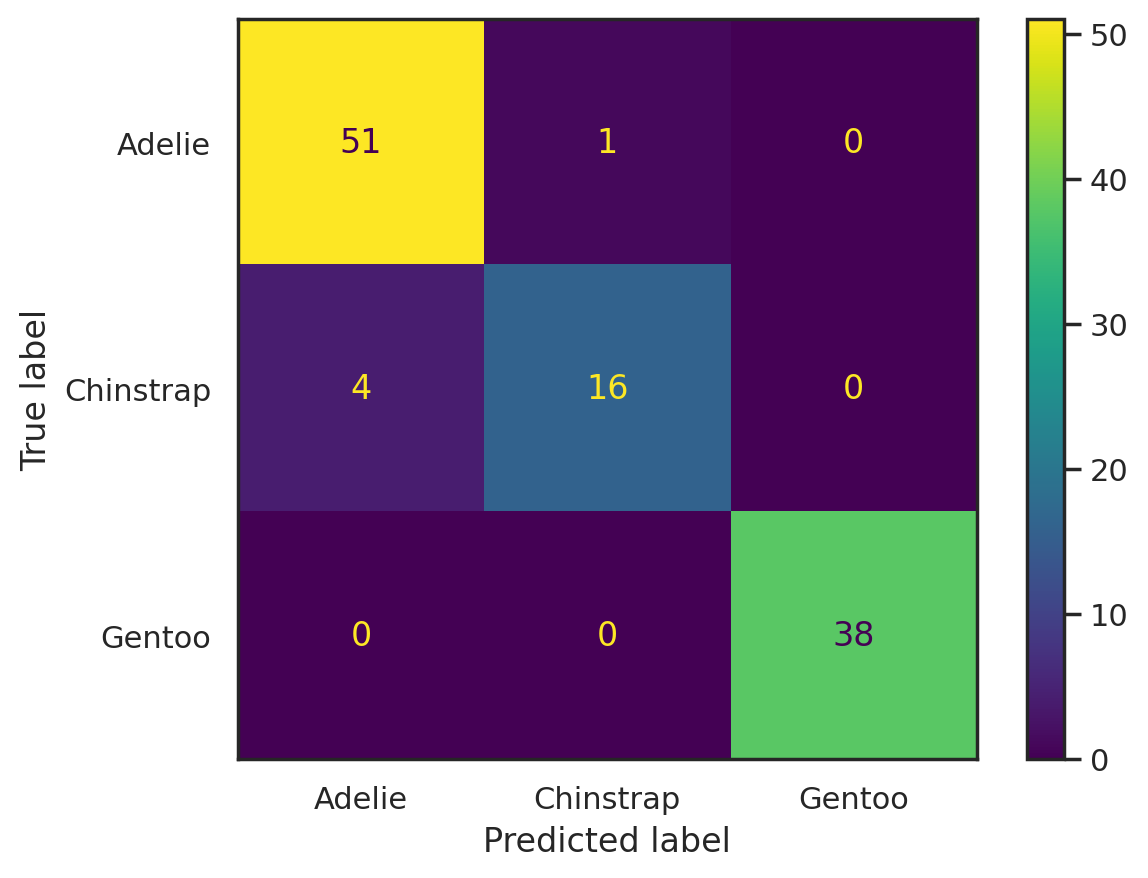

In [11]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

acc_train = accuracy_score(y_train, yhat_train)

# calculate the test set error
acc_test = accuracy_score(y_test, yhat_test)

print(f'training set accuracy (n={y_train.shape[0]}): {acc_train:4.3f}')
print(f'test set accuracy (n={y_test.shape[0]}): {acc_test:4.3f}')
print()
print('classificiation report on test set performance')
print(classification_report(y_test, yhat_test))
print()

with sns.axes_style('white'):
    ConfusionMatrixDisplay.from_predictions(y_test, yhat_test)

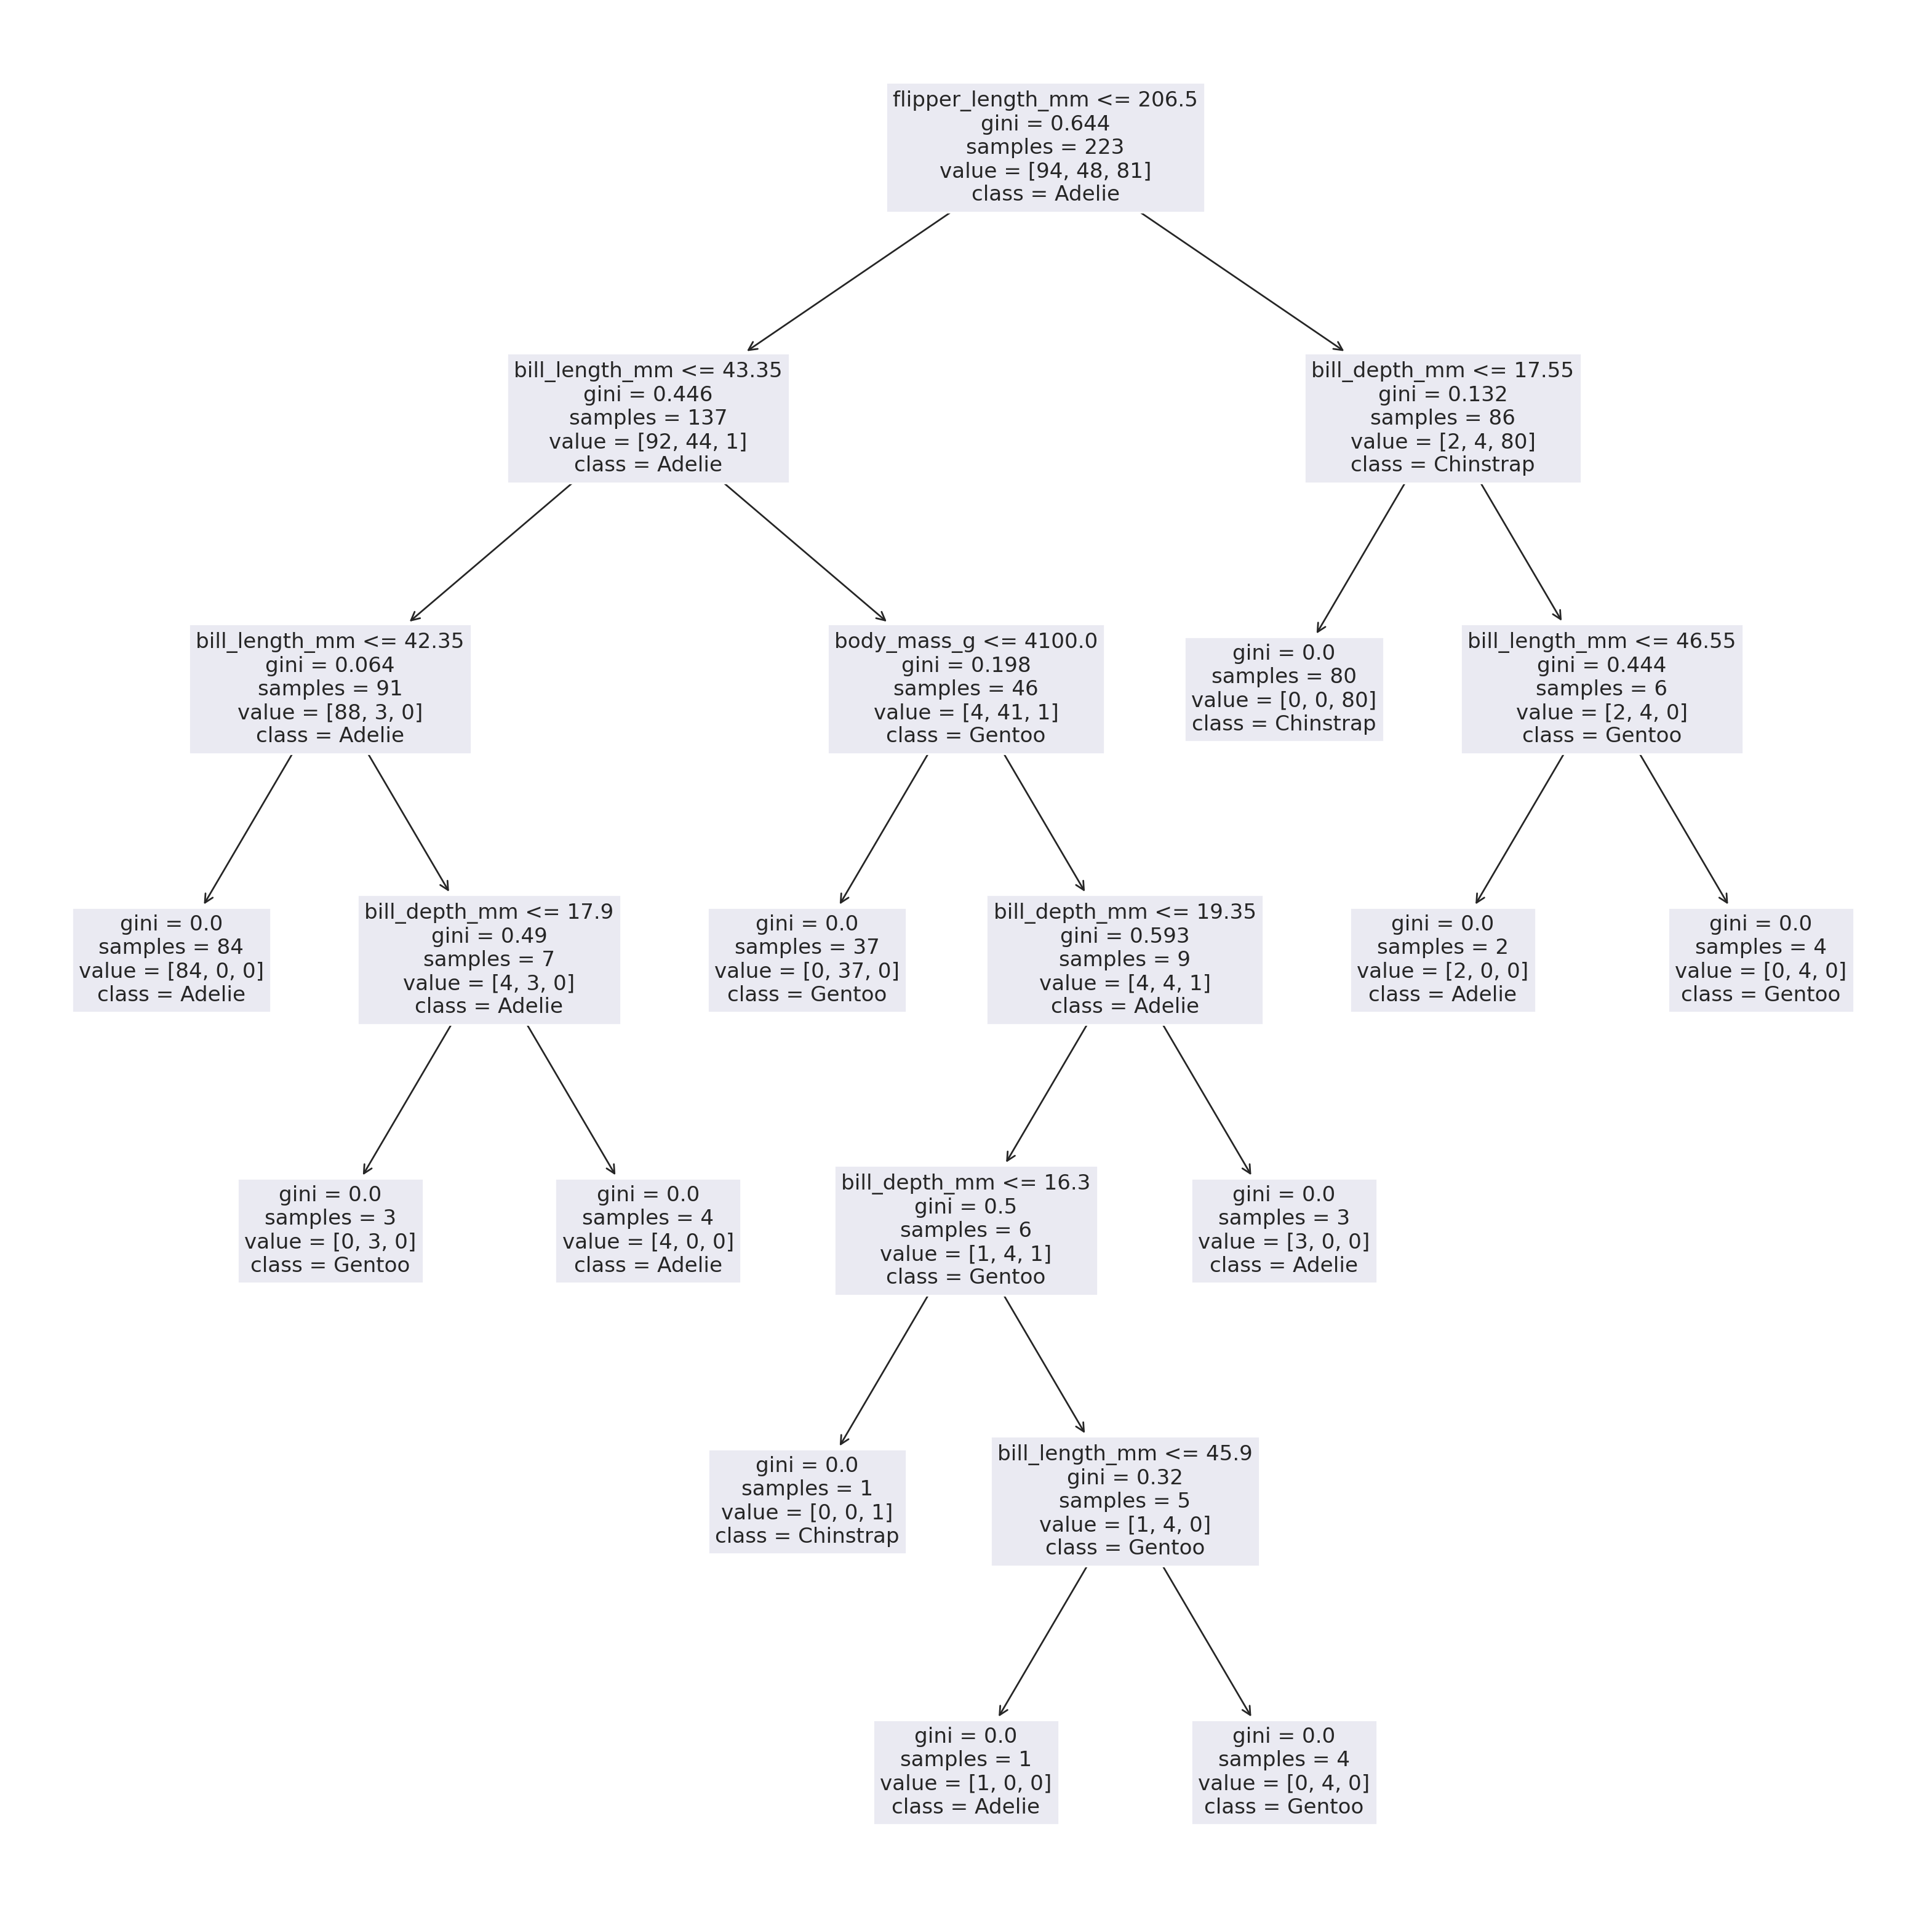

In [12]:
# great!  so what does our decision tree look like?

from sklearn.tree import plot_tree

# we need a bigger figure than normal for this plot
fig, axes = plt.subplots(figsize=(20,20))

plot_tree(model, 
          feature_names=X_train.columns, 
          class_names=y_train.drop_duplicates().to_list(),
          ax=axes);

Hmmm.  What do you think these feature_importances below are?  Do the numbers match up to anything related to the tree plot above? Hint: they do. 

In [13]:
model.feature_names_in_, model.feature_importances_

(array(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
        'body_mass_g'], dtype=object),
 array([0.36784717, 0.11031687, 0.49570077, 0.02613519]))

One thing I was wondering, is it possible to increase the accuracy of the predictions by including sex.  A bit of domain knowledge is helpful here... many species have different sized males and females, and you could easily see that impacting prediction accuracy, where males of smaller species might have measurements similar to females of larger species, causing misclassification.

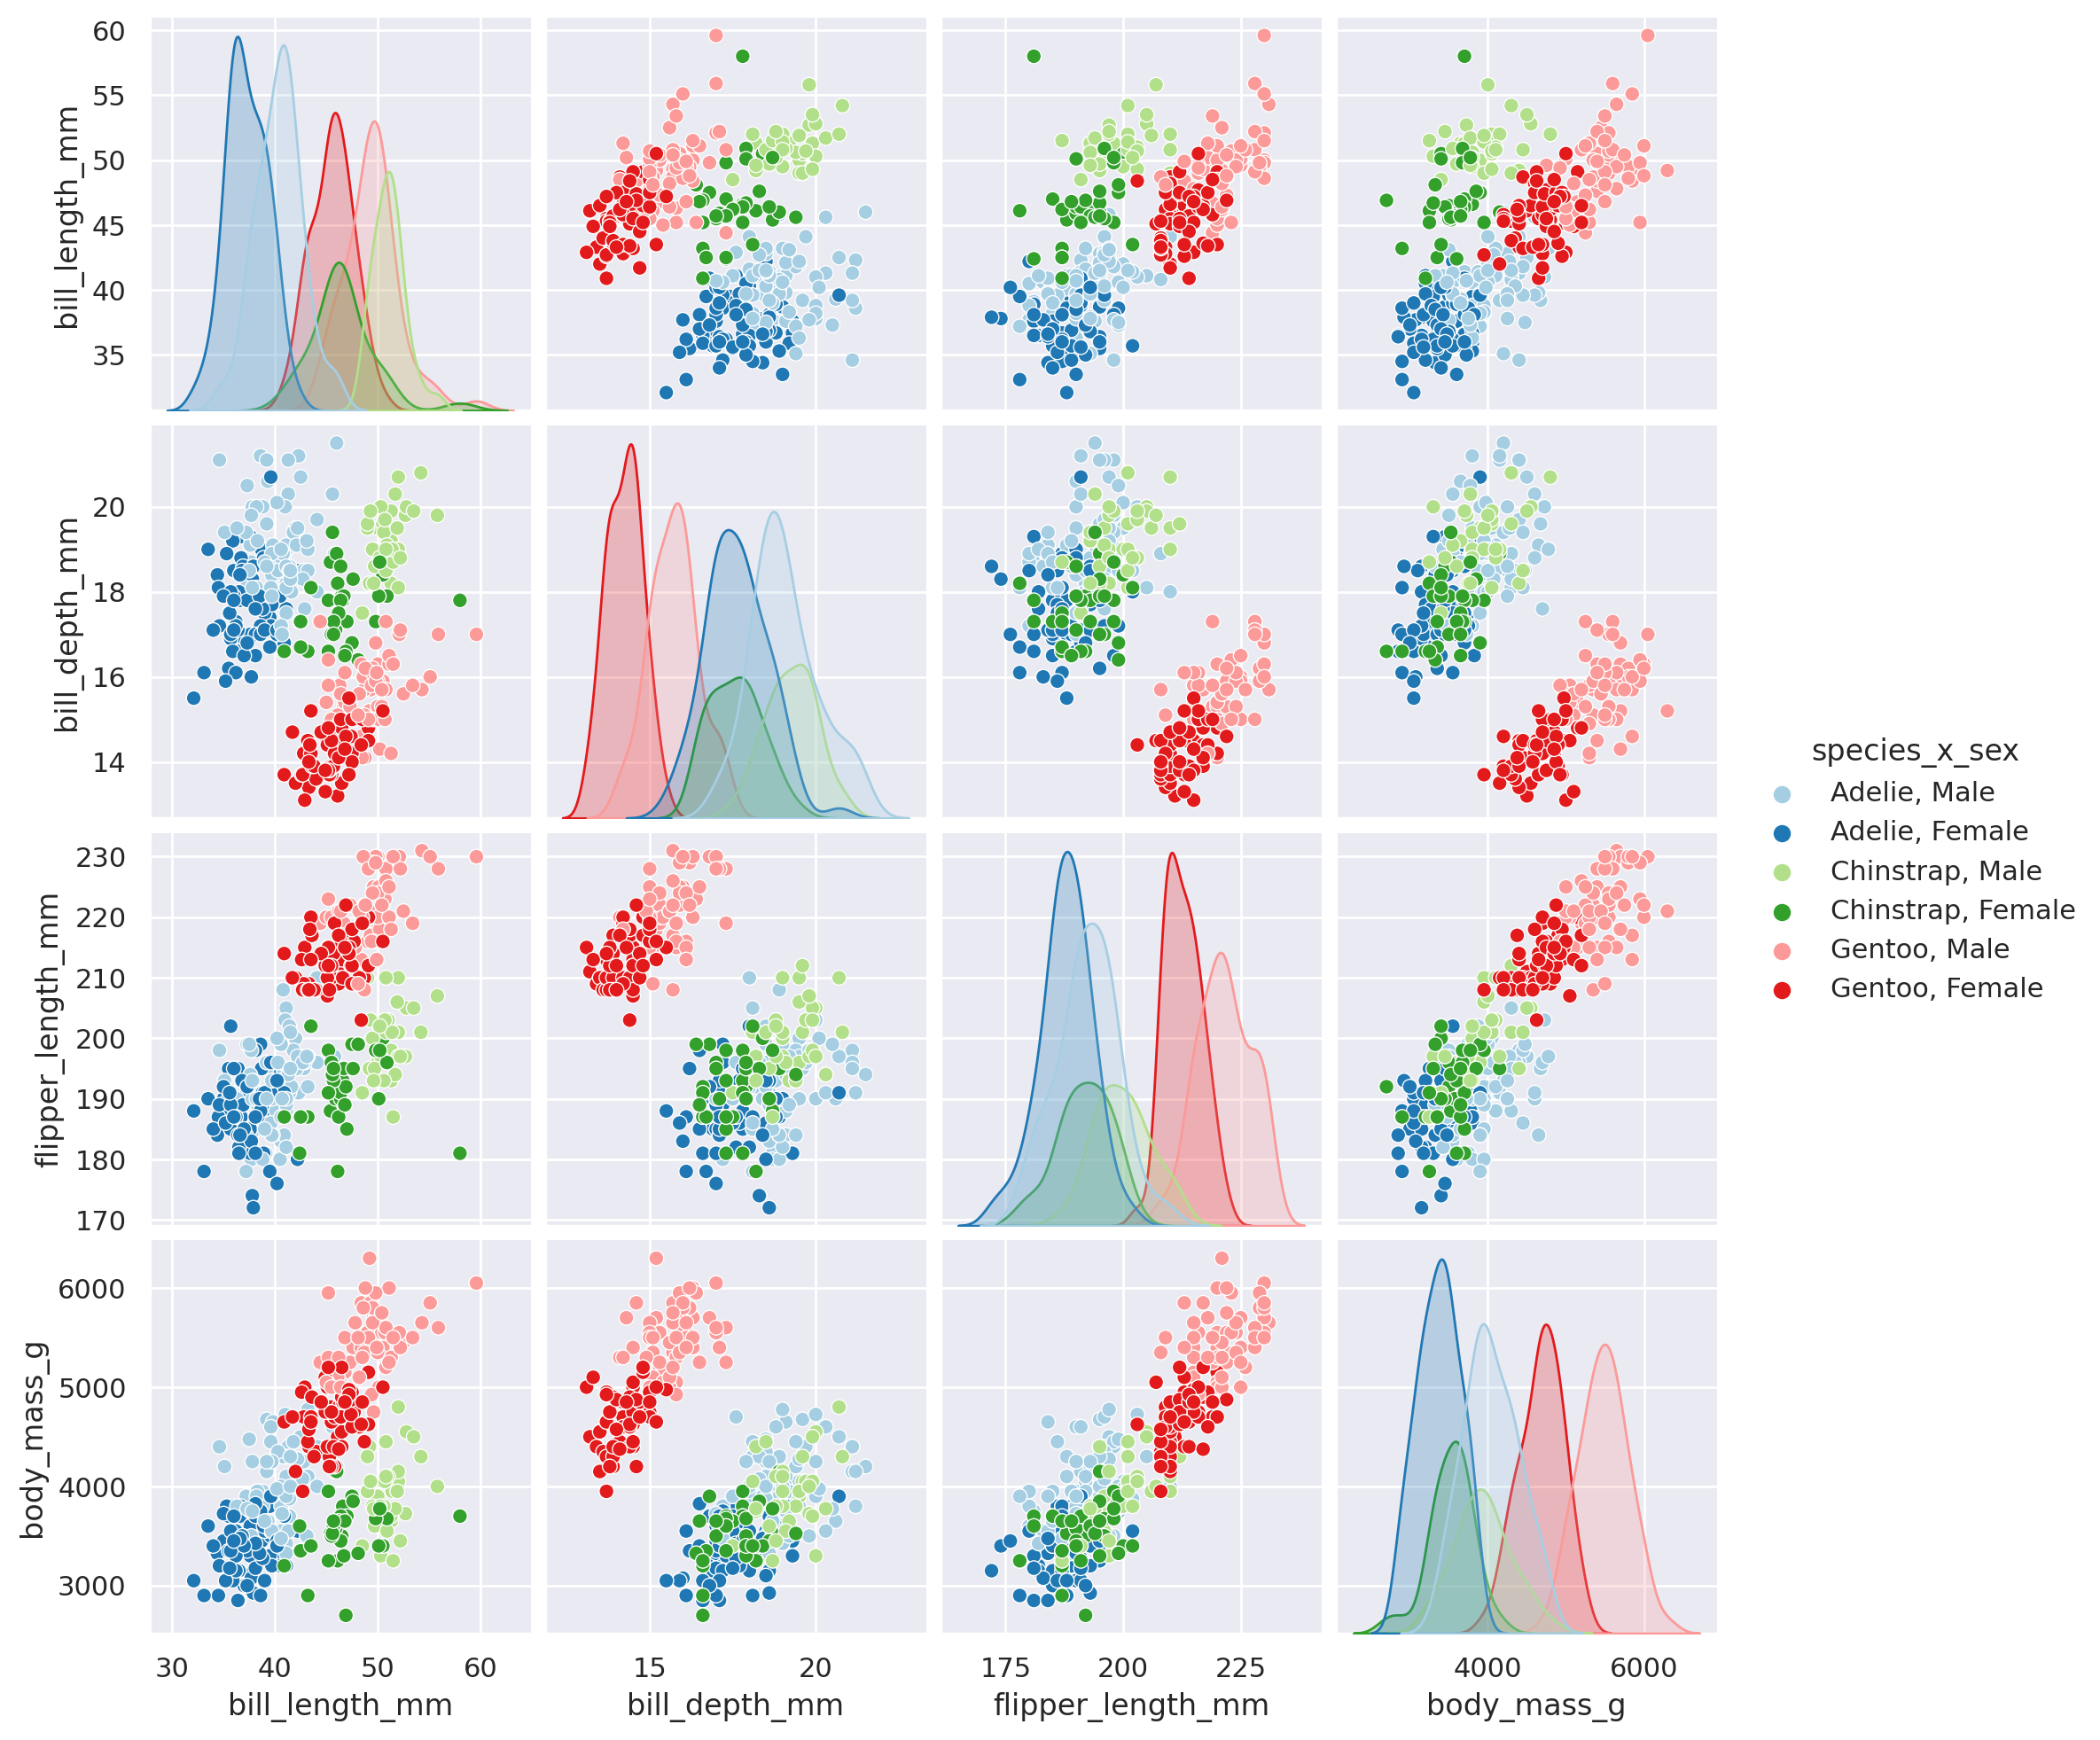

In [14]:

# make a combo category
penguins['species_x_sex'] = penguins['species']+', '+penguins['sex']

# this makes color sequence light/dark of the same color
# to encode sex for a given species, see seaborn docs
with sns.color_palette("Paired"):

    # pariplot shows all pairs of real valued variables
    sns.pairplot(penguins, hue='species_x_sex', 
                 hue_order=[ # forces the right order of colors 
                    'Adelie, Male', 'Adelie, Female',
                    'Chinstrap, Male', 'Chinstrap, Female',
                    'Gentoo, Male', 'Gentoo, Female']
                );

Yep, it sure looks like there is indeed a systematic sex based difference in size across all 3 species.  so lets do it again, this time we will try to improve our classification accuracy by including sex as a feature.

Now one thing... sex is a categorical feature, and so it needs transformation. And while its a binary feature in this dataset, we will just go ahead and one-hot encode it for safety.  In fact, while some sklearn algorithms will handle categorical inputs with ease, decision tree classifier is one of the ones that requires us to one-hot a categorical feature before it will work right.


In [15]:

# here's our raw data, this time include sex!
X = penguins[['bill_length_mm', 'bill_depth_mm', 
                  'flipper_length_mm', 'body_mass_g', 'sex']]
y = penguins['species']

# here's our training set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(223, 5) (110, 5) (223,) (110,)


In [16]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# transformers
onehot = OneHotEncoder() # use me for categorical data
scaler = StandardScaler() # for some algos, you need me for numerical data
                          # for other algos, you don't need it!

In [17]:
# Whenever we do any kind of preprocessing 
# (e.g. transformation or normalization)
# to our data it is CRITICAL to fit the preprocessor on training data
# NOT all the data.  If you fit all the data then you are leaking
# information from the test set into training set, and therefore
# you are allowing overfitting

onehot.fit( X_train[['sex']] )

# the to_frame() thing is only necessary becuase onehot expects a
# 2d array, and a single column is a 1d array.  if we have multiple
# columns to onehot we wouldn't need to_frame() and it wouldn't 
# exist anyway as it would already be a 2d dataframe


OneHotEncoder()

In [18]:
# add new one hot encoded gender categories to datasets
# ends up as a numpy sparse matrix, so we need to densify it
# to assign it back into the dataframe
X_train.loc[:, onehot.categories_[0]] = onehot.transform(X_train[['sex']]).todense()
X_test.loc[:, onehot.categories_[0]] = onehot.transform(X_test[['sex']]).todense()

# drop the old text label category "sex"
X_train.drop('sex', axis='columns', inplace=True)
X_test.drop('sex', axis='columns', inplace=True)

X_train

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,Female,Male
44,37.0,16.9,185.0,3000.0,1.0,0.0
318,48.4,14.4,203.0,4625.0,1.0,0.0
110,38.1,16.5,198.0,3825.0,1.0,0.0
161,51.3,19.9,198.0,3700.0,0.0,1.0
199,49.0,19.6,212.0,4300.0,0.0,1.0
...,...,...,...,...,...,...
194,50.9,19.1,196.0,3550.0,0.0,1.0
77,37.2,19.4,184.0,3900.0,0.0,1.0
112,39.7,17.7,193.0,3200.0,1.0,0.0
277,45.5,15.0,220.0,5000.0,0.0,1.0


training set accuracy (n=223): 1.000
test set accuracy (n=110): 0.964

classificiation report on test set performance
              precision    recall  f1-score   support

      Adelie       0.93      1.00      0.96        52
   Chinstrap       1.00      0.80      0.89        20
      Gentoo       1.00      1.00      1.00        38

    accuracy                           0.96       110
   macro avg       0.98      0.93      0.95       110
weighted avg       0.97      0.96      0.96       110




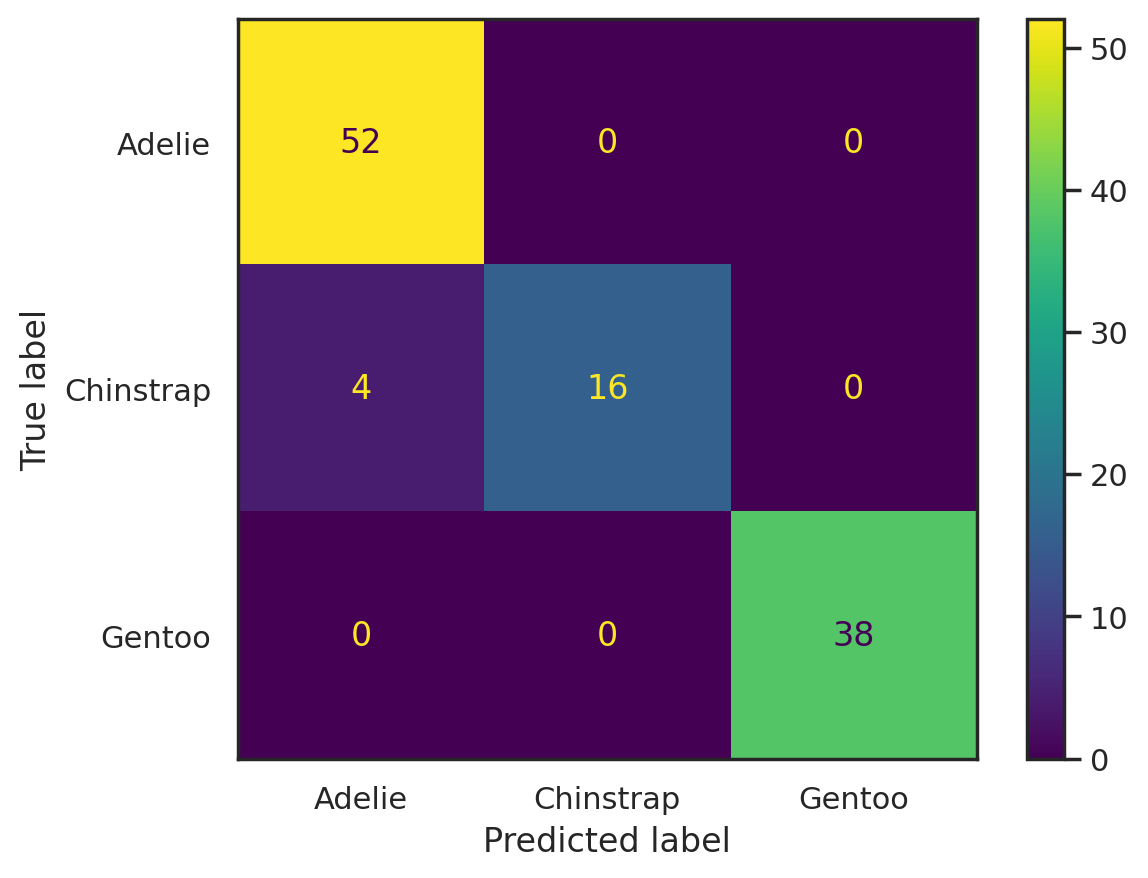

In [19]:
model.fit(X_train,y_train);

yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

acc_train = accuracy_score(y_train, yhat_train)
acc_test = accuracy_score(y_test, yhat_test)

print(f'training set accuracy (n={y_train.shape[0]}): {acc_train:4.3f}')
print(f'test set accuracy (n={y_test.shape[0]}): {acc_test:4.3f}')
print()
print('classificiation report on test set performance')
print(classification_report(y_test, yhat_test))
print()

# use this `with` to avoid ugly gridlines in the confusion matrix plot
# that an earlier seaborn style statement would have put there
# this with is not necessary if you havaen't been using seaborn above
with sns.axes_style('white'):
    ConfusionMatrixDisplay.from_predictions(y_test, yhat_test)

So by using a one-hot encoded sex feature we gained 4% accuracy (going from 95% w/o it to 99% w/ it).  In particular without a sex feature, 5 Chinstrap and Adelie penguins were confused with other. With that feature just a single penguin was misclassified. 

Next up, try to apply a k-NN (lets use k=7) to this data.  Sklearn docs are your best friend.  The main thing you will need is a new `model` but lots of the rest of it can stay the same (i.e. you can copy/paste some of the cells above).

Let me suggest to you that if you want to do the best possible performance, then you will need to use the standard scalar transformer on the measurement variables (aka. z-score aka standardize the variables). This is because body mass is a few orders of magnitude bigger than other measurements.  

And besides trying to work out how to do this in sklearn, I'm going to pose you the following questions as well:
1. Why must we scaler() the measurement data for kNN to get it's best performance?
1. Why is it not necessary to scaler() the measurement data for a decision tree?
1. Run it both with and without the scaler().  What performance difference do you get on test set accuracy?

In [23]:
from sklearn.neighbors import KNeighborsClassifier

# YOUR CODE HERE
model= KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [24]:
# here's our raw data, this time include sex!
X = penguins[['bill_length_mm', 'bill_depth_mm', 
                  'flipper_length_mm', 'body_mass_g', 'sex']]
y = penguins['species']

# here's our training set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(223, 5) (110, 5) (223,) (110,)


In [25]:
X_train_numerical = X_train.drop('sex',axis='columns')
X_test_numerical = X_test.drop('sex',axis='columns')
scaler.fit(X_train_numerical)

StandardScaler()

In [26]:
# add new one hot encoded gender categories to datasets
# ends up as a numpy sparse matrix, so we need to densify it
# to assign it back into the dataframe
X_train.loc[:, onehot.categories_[0]] = onehot.transform(X_train[['sex']]).todense()
X_test.loc[:, onehot.categories_[0]] = onehot.transform(X_test[['sex']]).todense()

# drop the old text label category "sex"
X_train.drop('sex', axis='columns', inplace=True)
X_test.drop('sex', axis='columns', inplace=True)

X_train

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,Female,Male
44,37.0,16.9,185.0,3000.0,1.0,0.0
318,48.4,14.4,203.0,4625.0,1.0,0.0
110,38.1,16.5,198.0,3825.0,1.0,0.0
161,51.3,19.9,198.0,3700.0,0.0,1.0
199,49.0,19.6,212.0,4300.0,0.0,1.0
...,...,...,...,...,...,...
194,50.9,19.1,196.0,3550.0,0.0,1.0
77,37.2,19.4,184.0,3900.0,0.0,1.0
112,39.7,17.7,193.0,3200.0,1.0,0.0
277,45.5,15.0,220.0,5000.0,0.0,1.0


In [27]:
# add new scaler transformed version of the data
X_train.loc[:, scaler.feature_names_in_] = scaler.transform(X_train_numerical)
X_test.loc[:, scaler.feature_names_in_] = scaler.transform(X_test_numerical)

training set accuracy (n=223): 0.996
test set accuracy (n=110): 0.991

classificiation report on test set performance
              precision    recall  f1-score   support

      Adelie       0.98      1.00      0.99        52
   Chinstrap       1.00      0.95      0.97        20
      Gentoo       1.00      1.00      1.00        38

    accuracy                           0.99       110
   macro avg       0.99      0.98      0.99       110
weighted avg       0.99      0.99      0.99       110




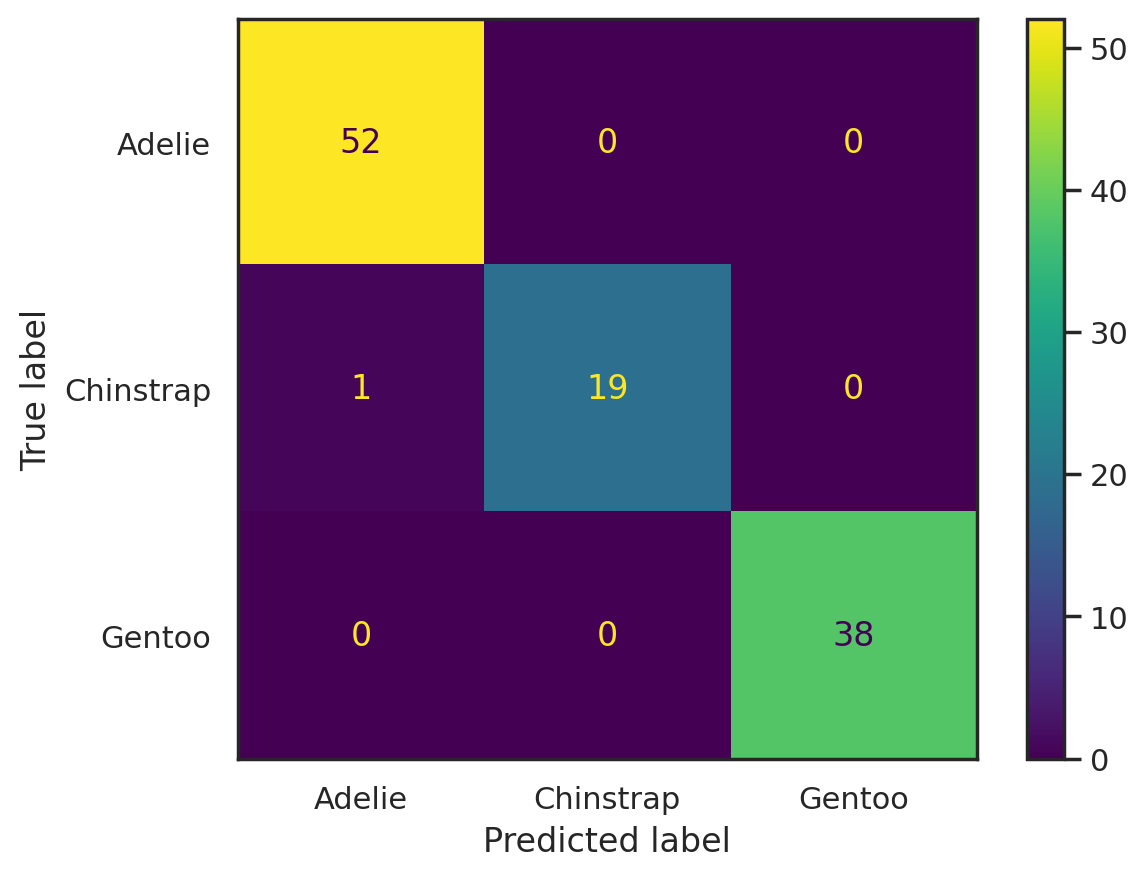

In [28]:
model.fit(X_train,y_train)

yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

acc_train = accuracy_score(y_train, yhat_train)
acc_test = accuracy_score(y_test, yhat_test)

print(f'training set accuracy (n={y_train.shape[0]}): {acc_train:4.3f}')
print(f'test set accuracy (n={y_test.shape[0]}): {acc_test:4.3f}')
print()
print('classificiation report on test set performance')
print(classification_report(y_test, yhat_test))
print()

# use this `with` to avoid ugly gridlines in the confusion matrix plot
# that an earlier seaborn style statement would have put there
# this with is not necessary if you havaen't been using seaborn above
with sns.axes_style('white'):
    ConfusionMatrixDisplay.from_predictions(y_test, yhat_test)

Now let's compare the above result to one where we don't standardize the variables!!

In [29]:
# here's our raw data, this time include sex!
X = penguins[['bill_length_mm', 'bill_depth_mm', 
                  'flipper_length_mm', 'body_mass_g', 'sex']]
y = penguins['species']

# here's our training set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(223, 5) (110, 5) (223,) (110,)


In [33]:
# add one hot encoded gender categories to datasets
# BUT DONT add scaler normalized data this time!
# feel free to copy paste from previous cells

onehot.fit( X_train[['sex']] )




OneHotEncoder()

In [ ]:
model.fit(X_train,y_train)

yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

acc_train = accuracy_score(y_train, yhat_train)
acc_test = accuracy_score(y_test, yhat_test)

print(f'training set accuracy (n={y_train.shape[0]}): {acc_train:4.3f}')
print(f'test set accuracy (n={y_test.shape[0]}): {acc_test:4.3f}')
print()
print('classificiation report on test set performance')
print(classification_report(y_test, yhat_test))
print()

# use this `with` to avoid ugly gridlines in the confusion matrix plot
# that an earlier seaborn style statement would have put there
# this with is not necessary if you havaen't been using seaborn above
with sns.axes_style('white'):
    ConfusionMatrixDisplay.from_predictions(y_test, yhat_test)

Look at that!  If you did the same thing I did, you'll end up with 81.8% accuracy without standardizing the numeric variables vs 99.1% accuracy when you did.  That's a substantial change! 